In [3]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import matplotlib.pyplot as plt
import fitsio
import glob

import numpy as np
import healpy as hp
import astropy.io.fits as pyfits
import xlens
import smatch
import astropy.table as astTable

In [2]:
def get_ngal_in_healpix(catalog):
    # set the nside
    nside = 1024
    npix = hp.nside2npix(nside)
    
    # initialize a count map
    ngal = np.zeros(npix, dtype=int)
    
    # ra, dec of your galaxy catalog (in degrees)
    # these should be arrays of equal length
    ra = catalog['ra']        # shape (n,)
    dec = catalog['dec']      # shape (n,)
    
    # convert to theta (colatitude) and phi (longitude) in radians
    theta = np.deg2rad(90.0 - dec)
    phi = np.deg2rad(ra)
    
    # convert to healpix pixel indices (in nested ordering)
    pix = hp.ang2pix(nside, theta, phi, nest=True)
    
    # Count galaxies per pixel
    np.add.at(ngal, pix, 1)
    return ngal

In [9]:
field = "hectomap"
fname = f"/gpfs02/work/xiangchong.li/work/hsc_data/s23b/deepCoadd_anacal3/fields_color/{field}.fits"
data = fitsio.read(fname)

In [11]:
data["patch"]

array([305, 305, 305, ..., 805, 805, 805], dtype='>i2')

In [6]:
ls /gpfs02/work/xiangchong.li/work/hsc_data/s23b/deepCoadd_anacal3/fields

autumn1.fits  hectomap.fits  spring2.fits
autumn2.fits  spring1.fits   spring3.fits


In [12]:
np.argsort([2,1,4,3,0])

array([4, 1, 0, 3, 2])

In [15]:
data["tract"]

array([15809, 15809, 15809, ..., 16012, 16012, 16012], dtype='>i2')

In [16]:
data["patch"]

array([305, 305, 305, ..., 805, 805, 805], dtype='>i2')

In [19]:
tplist = fitsio.read("/gpfs02/work/xiangchong.li/work/hsc_data/s23b/tracts_fdfc_v1_final.fits")

In [22]:
np.intersect1d(tplist["tract"] * 1000 + tplist["patch"], data["tract"] * 1000 + data["patch"])

array([], dtype=int32)

In [24]:
data["tract"] * 1000 + data["patch"]

array([15129, 15129, 15129, ..., 22021, 22021, 22021], dtype=int16)

In [27]:
np.sum((tplist["tract"] * 1000 + tplist["patch"]) == 15129

0

In [30]:
len(tplist)

37057

In [33]:
tplist[tplist["tract"] == 15809]["patch"]

array([  6,   8, 106, 107, 207, 208, 305, 306, 307, 308, 405, 406, 407,
       408, 505, 506, 507, 508, 606, 607, 608], dtype='>i4')

In [34]:
data[data["tract"] == 15809]["patch"]

array([305, 305, 305, ..., 608, 608, 608], dtype='>i2')

In [29]:
data["tract"]

array([15809, 15809, 15809, ..., 16012, 16012, 16012], dtype='>i2')

In [21]:
tplist["patch"]

array([  7,   8, 107, ..., 803, 804, 805], dtype='>i4')

In [7]:
field_list = ["spring1", "spring2", "spring3", "autumn1", "autumn2", "hectomap"]
npix = hp.nside2npix(NSIDE)
ngals = np.zeros(npix, dtype=int)
for field in field_list:
    fname = f"/gpfs02/work/xiangchong.li/work/hsc_data/s23b/deepCoadd_anacal2/{field}.fits"
    data = fitsio.read(fname)
    ngals = ngals + get_ngal_in_healpix(data)

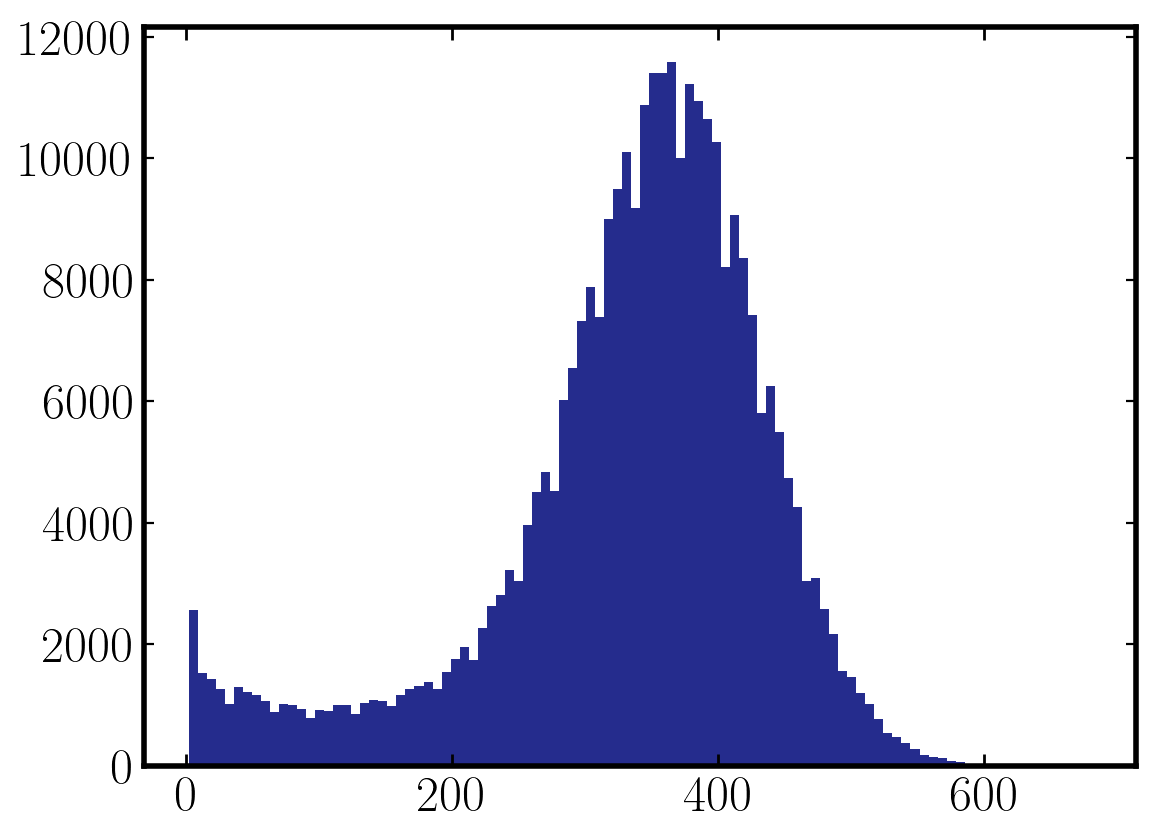

In [8]:
_ = plt.hist(ngals[ngals>1], bins=100)

In [9]:
mask = (ngals>5)
hp.write_map(
    "fdfc_hp_window.fits", 
    mask.astype(np.bool_),
    dtype=np.bool_, nest=True, 
    overwrite=True,
)

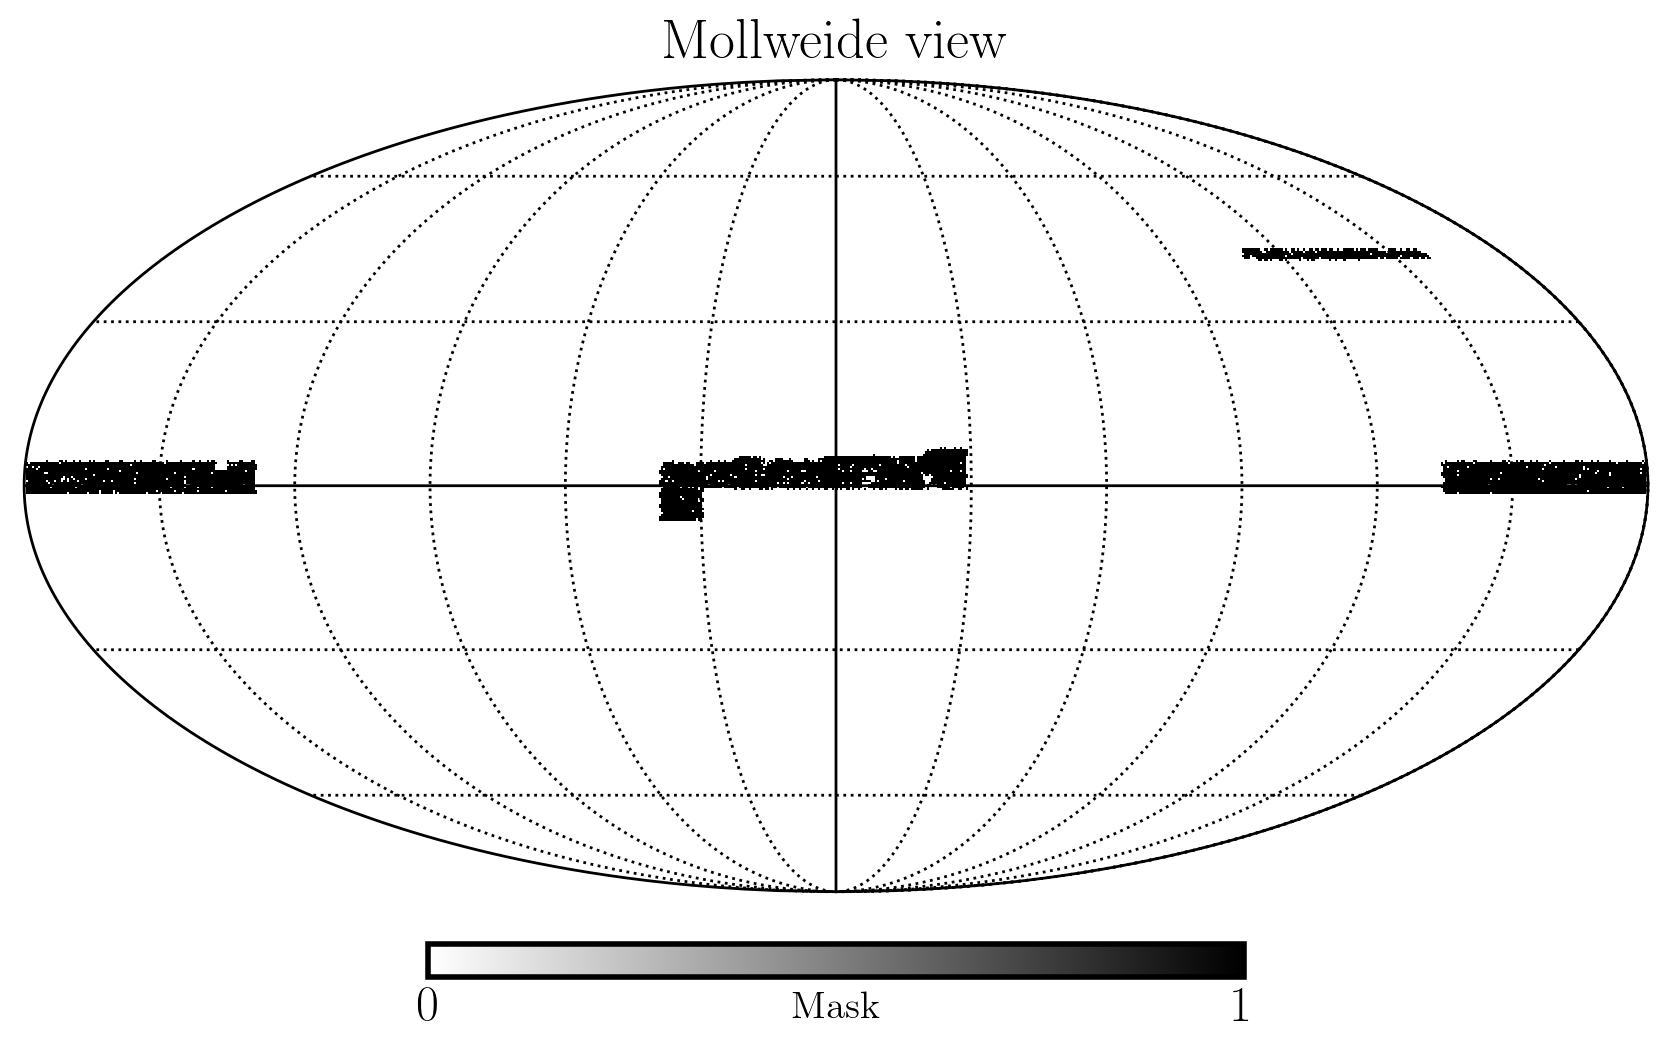

In [3]:
mask = hp.read_map("fdfc_hp_window.fits", nest=True, dtype=bool)
hp.mollview(mask.astype(float), nest=True, cmap="gray_r", unit="Mask")
hp.graticule()

plt.show()

In [12]:
NSIDE = 1024
field_list = ["spring1", "spring2", "spring3", "autumn1", "autumn2", "hectomap"]
for field in field_list:
    fname = f"/gpfs02/work/xiangchong.li/work/hsc_data/s23b/db_star/fields/{field}.fits"
    data = pyfits.getdata(fname)
    ra = data['i_ra']        
    dec = data['i_dec']     
    
    theta = np.deg2rad(90.0 - dec)
    phi = np.deg2rad(ra)
    
    # Convert to HEALPix pixel indices (in NESTED ordering)
    pix = hp.ang2pix(NSIDE, theta, phi, nest=True)
    mm = mask[pix]
    data = data[mm]
    print(np.sum(mm) / len(mm))
    pyfits.writeto(fname, data, overwrite=True)
    del data

0.9940237693393307
0.9955035150416098
0.9955717160878379
0.9938660713399154
0.9945501759878842
0.9955437729179639


In [89]:
if False:
    NSIDE = 1024
    field_list = ["spring1", "spring2", "spring3", "autumn1", "autumn2", "hectomap"]
    for field in field_list:
        fname = f"/gpfs02/work/xiangchong.li/work/hsc_data/s23b/db_star/fields/{field}.fits"
        data = pyfits.getdata(fname)
        data["i_higherordermomentspsf_13"] = -data["i_higherordermomentspsf_13"]
        data["i_higherordermomentspsf_31"] = -data["i_higherordermomentspsf_31"]
        data["i_higherordermomentssource_13"] = -data["i_higherordermomentssource_13"]
        data["i_higherordermomentssource_31"] = -data["i_higherordermomentssource_31"]
        pyfits.writeto(fname, data, overwrite=True)

In [1]:
field_list = ["spring1", "spring2", "spring3", "autumn1", "autumn2", "hectomap"]
for field in field_list:
    fname = f"/gpfs02/work/xiangchong.li/work/hsc_data/s23b/deepCoadd_anacal3/fields/{field}.fits"
    data = pyfits.getdata(fname) 
    fname = f"/gpfs02/work/xiangchong.li/work/hsc_data/s23b/deepCoadd_anacal3/fields_color/{field}.fits"
    data2 = pyfits.getdata(fname)
    common_ids, mm, _ = np.intersect1d(
        data2["object_id"], data["object_id"], return_indices=True
    )
    assert len(common_ids) == len(data)
    print(len(data) / len(data2))
    data2 = data2[mm]
    pyfits.writeto(fname, data2, overwrite=True)
    del data, data2, mm

0.9980023364328178
0.9984079371156495
0.9981367145095478
0.9982695235011404
0.9984471814081171
0.9985501622837676


In [14]:
field_list = ["spring1", "spring2", "spring3", "autumn1", "autumn2", "hectomap"]
for field in field_list:
    fname = f"/gpfs02/work/xiangchong.li/work/hsc_data/s23b/deepCoadd_anacal3/fields/{field}.fits"
    data = pyfits.getdata(fname)
    
    mm = (hsmask.get_values_pos(data["ra"], data["dec"]) == 0)
    print(np.sum(mm) / len(mm))
    data = data[mm]
    pyfits.writeto(fname, data, overwrite=True)
    del data, fname
    
    fname = f"/gpfs02/work/xiangchong.li/work/hsc_data/s23b/deepCoadd_anacal3/fields_color/{field}.fits"
    data = pyfits.getdata(fname)
    data = data[mm]
    pyfits.writeto(fname, data, overwrite=True)
    del data, mm

0.8939195483095288
0.929291119905368
0.9229555993390117
0.909684858907457
0.9211925437913516
0.9242381536327257


In [ ]:
fname = "/gpfs02/work/xiangchong.li/work/hsc_data/s23b/deepCoadd_anacal3/fields/hectomap.fits"
data = pyfits.getdata(fname)
mag = 27.0 - 2.5 * np.log10(data["flux"])
abse2 = data["e1"] ** 2.0 + data["e2"] ** 2.0
mask = (
    (mag < 24.5) &
    (abse2 < 0.09)
)
data = data[mask]
r1 = (
    data["de1_dg1"] * data["wsel"] +
    data["dwsel_dg1"] * data["e1"]
)
r2 = (
    data["de2_dg2"] * data["wsel"] +
    data["dwsel_dg2"] * data["e2"]
)

In [18]:
fname = "/gpfs02/work/xiangchong.li/work/hsc_data/s23b/deepCoadd_anacal3/fields_color/hectomap.fits"
data2 = pyfits.getdata(fname)
data2 = data2[mask]
psf_mxx = data2["i_hsmpsfmoments_shape11"]
psf_myy = data2["i_hsmpsfmoments_shape22"]
psf_mxy = data2["i_hsmpsfmoments_shape12"]
fwhm = 2.355 * (psf_mxx * psf_myy - psf_mxy**2)**0.25
variance = data2["i_variance_value"]

nside = 1024
npix = hp.nside2npix(nside)
ra = data['ra']        # shape (n,)
dec = data['dec']      # shape (n,)
theta = np.deg2rad(90.0 - dec)
phi = np.deg2rad(ra)
pix = hp.ang2pix(nside, theta, phi, nest=True)

In [34]:
hp.nside2pixarea(nside, degrees=True) * 3600

11.802566885782033

In [20]:
num_map = np.bincount(pix, minlength=npix)
mask_map = (num_map>0)
r1_map = np.bincount(pix, weights=r1, minlength=npix)
r2_map = np.bincount(pix, weights=r2, minlength=npix)
fwhm_map = np.bincount(pix, weights=fwhm, minlength=npix)
var_map = np.bincount(pix, weights=variance, minlength=npix)
input_map = np.bincount(pix, weights=data2["i_"], minlength=npix)

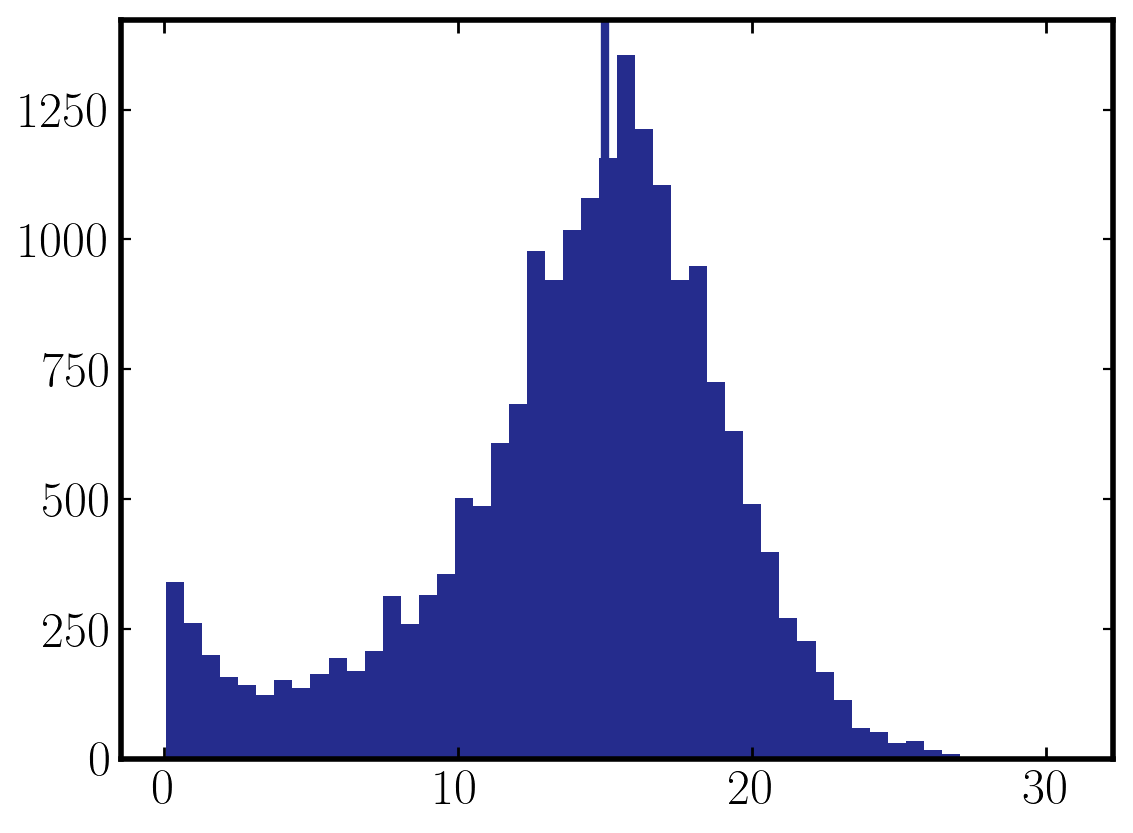

In [37]:
_ = plt.hist(num_map[mask_map] / 11.802, bins=50)
plt.axvline(15)

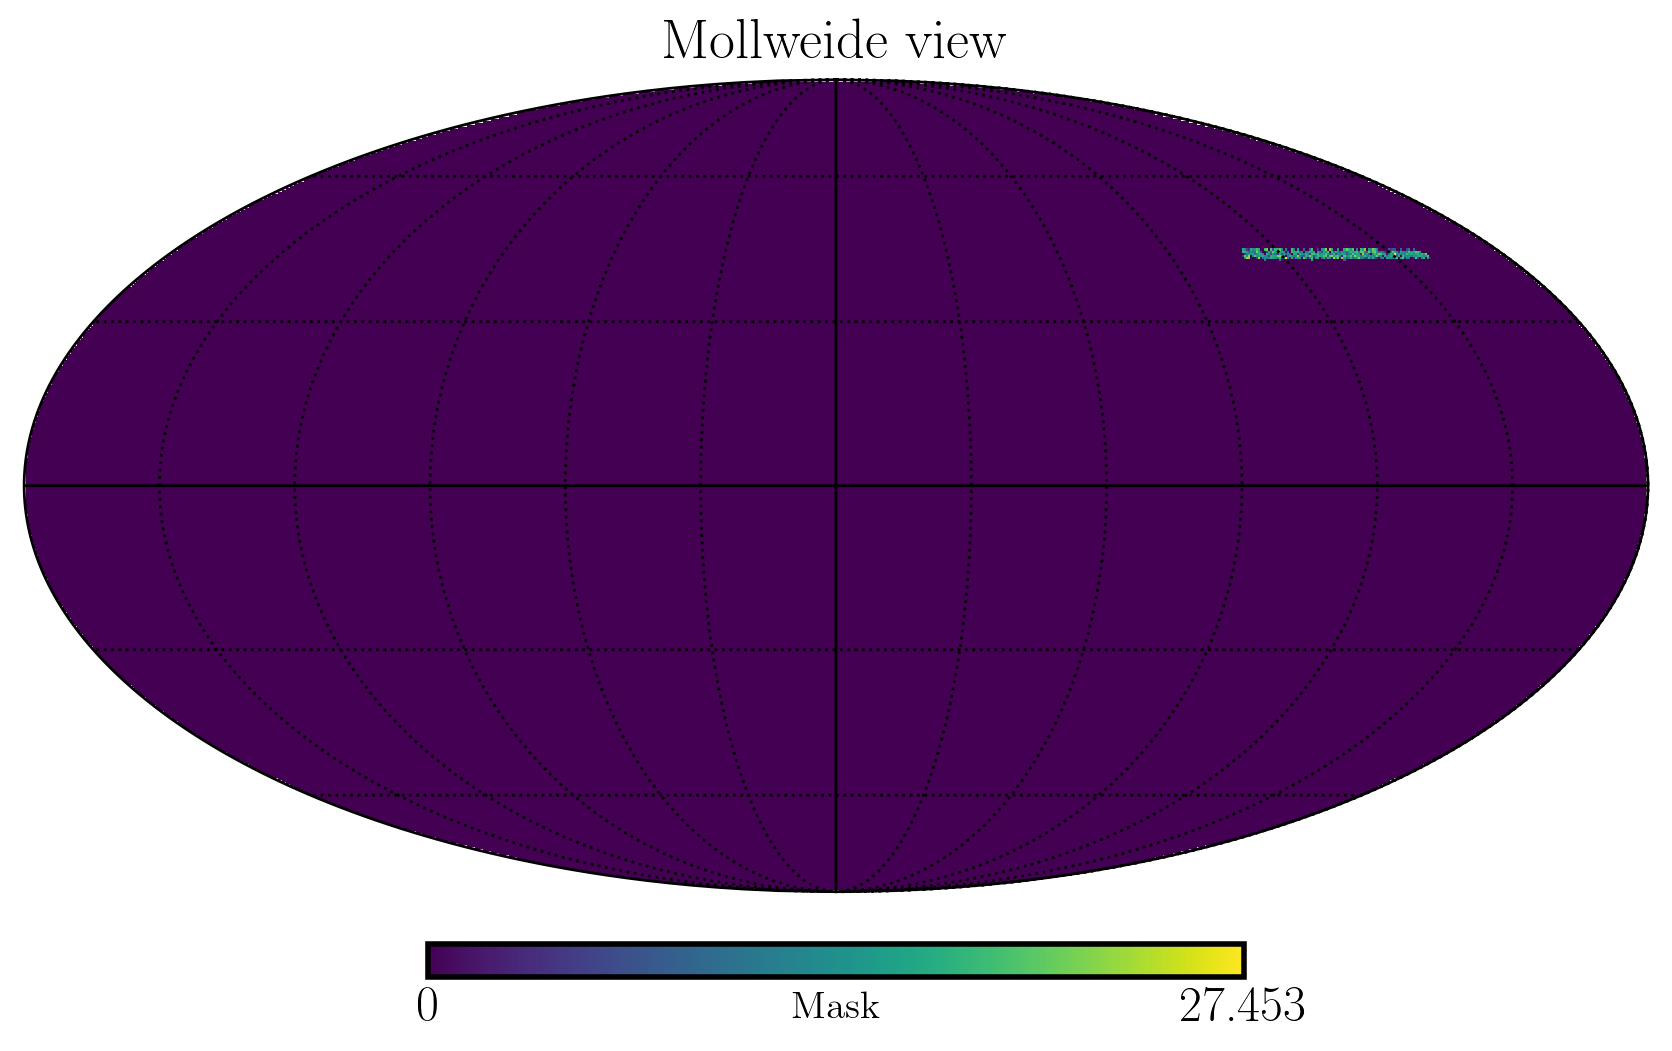

In [42]:
hp.mollview(num_map / 11.802, nest=True, cmap="viridis", unit="Mask")
hp.graticule()

plt.show()

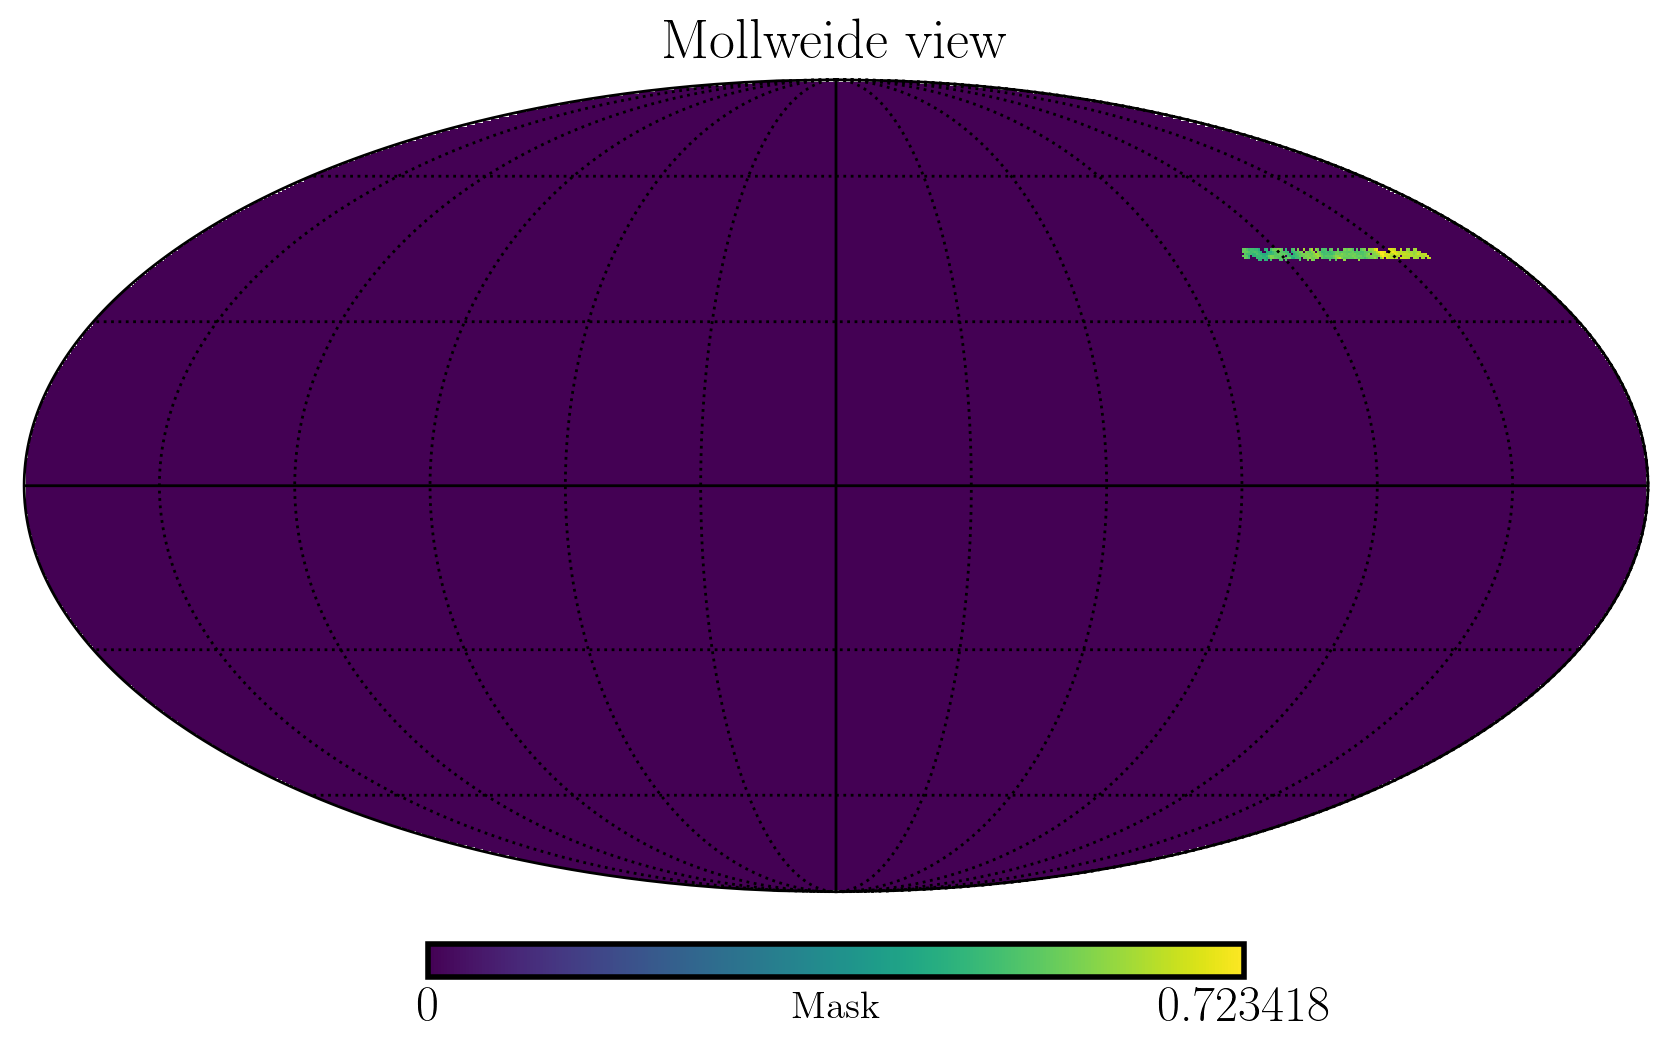

In [45]:
hp.mollview(fwhm_map / (num_map + 0.001), nest=True, cmap="viridis", unit="Mask")
hp.graticule()

plt.show()

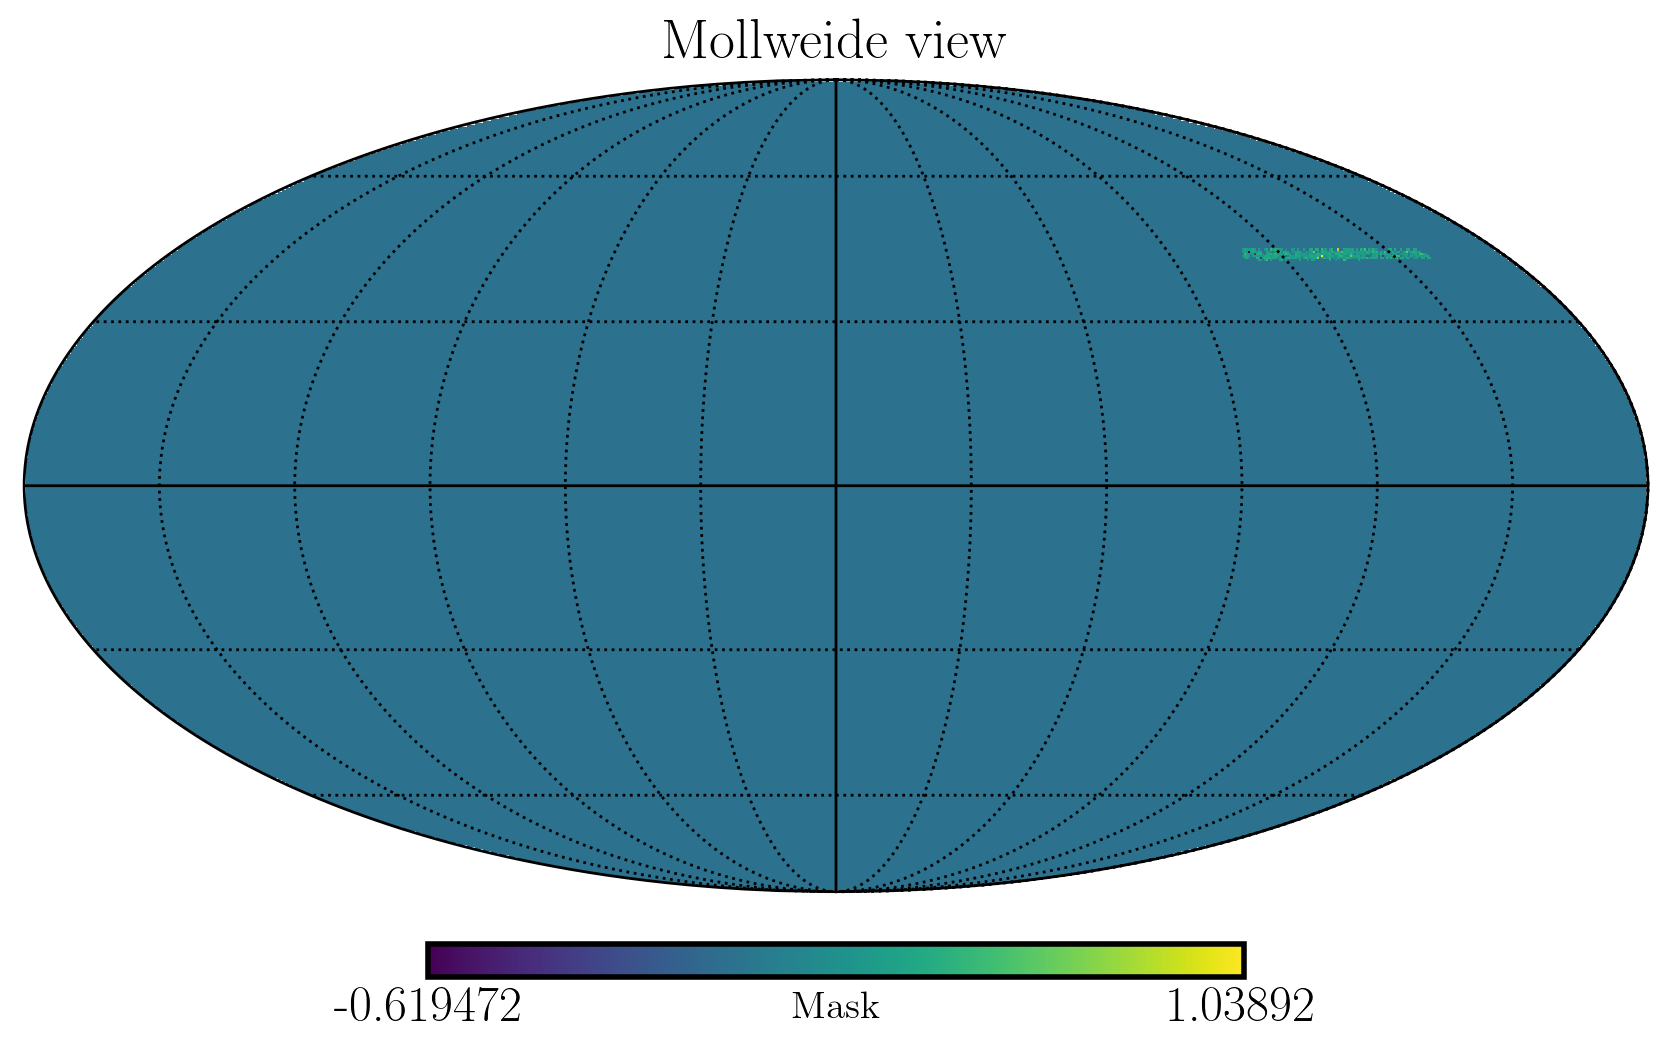

In [48]:
hp.mollview((r1_map + r2_map) / (num_map + 0.001) / 2.0, nest=True, cmap="viridis", unit="Mask")
hp.graticule()

plt.show()

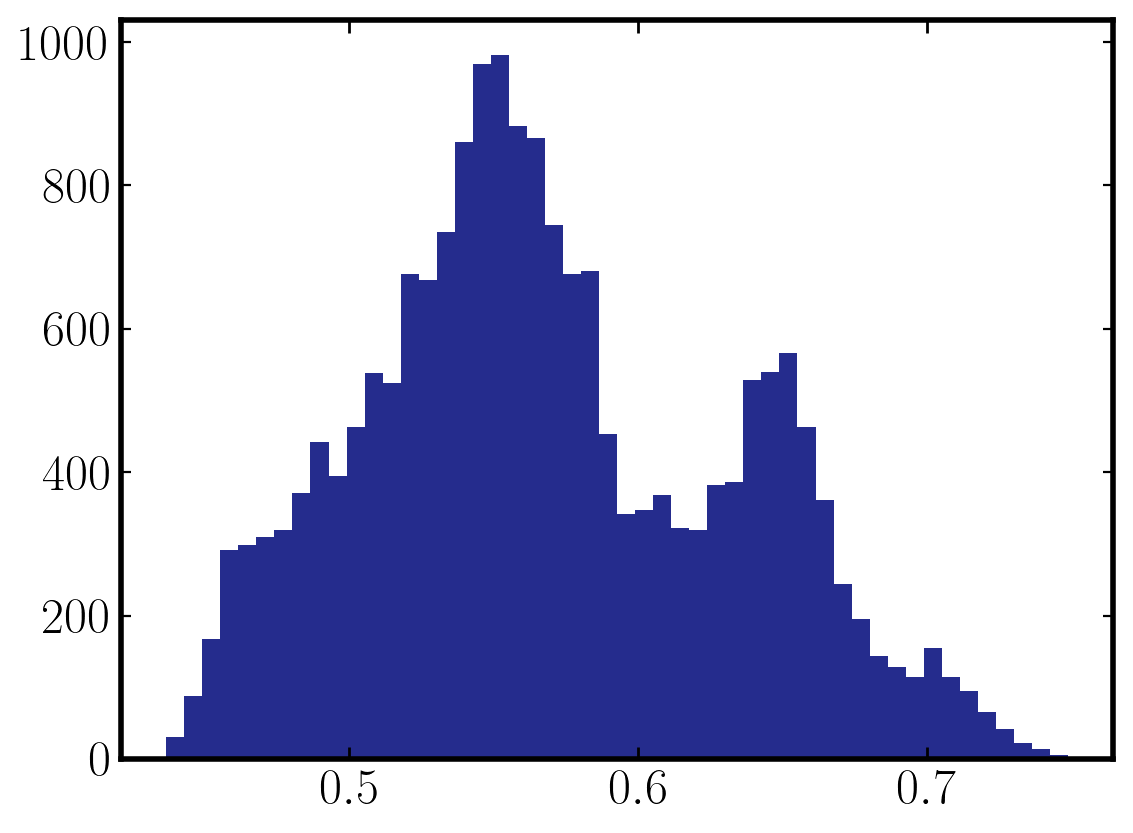

In [30]:
_ = plt.hist(fwhm_map[mask_map] / num_map[mask_map], bins=50)

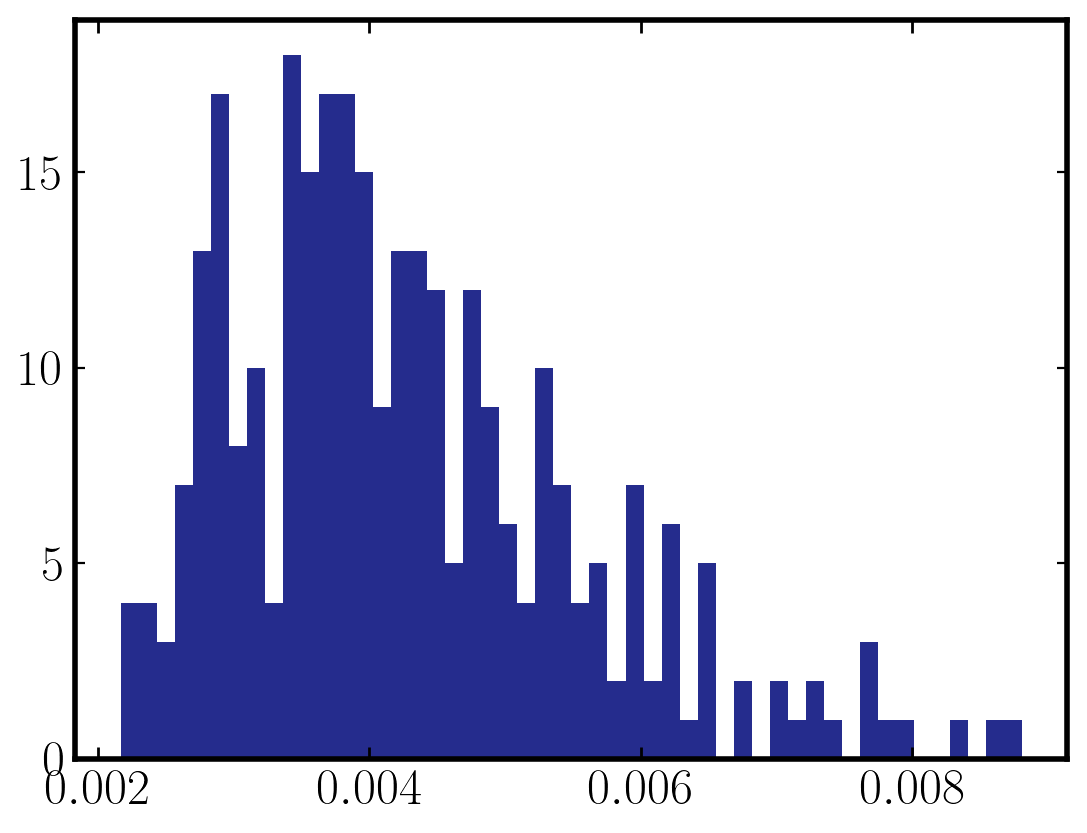

In [31]:
_ = plt.hist(var_map[mask_map] / num_map[mask_map], bins=50)

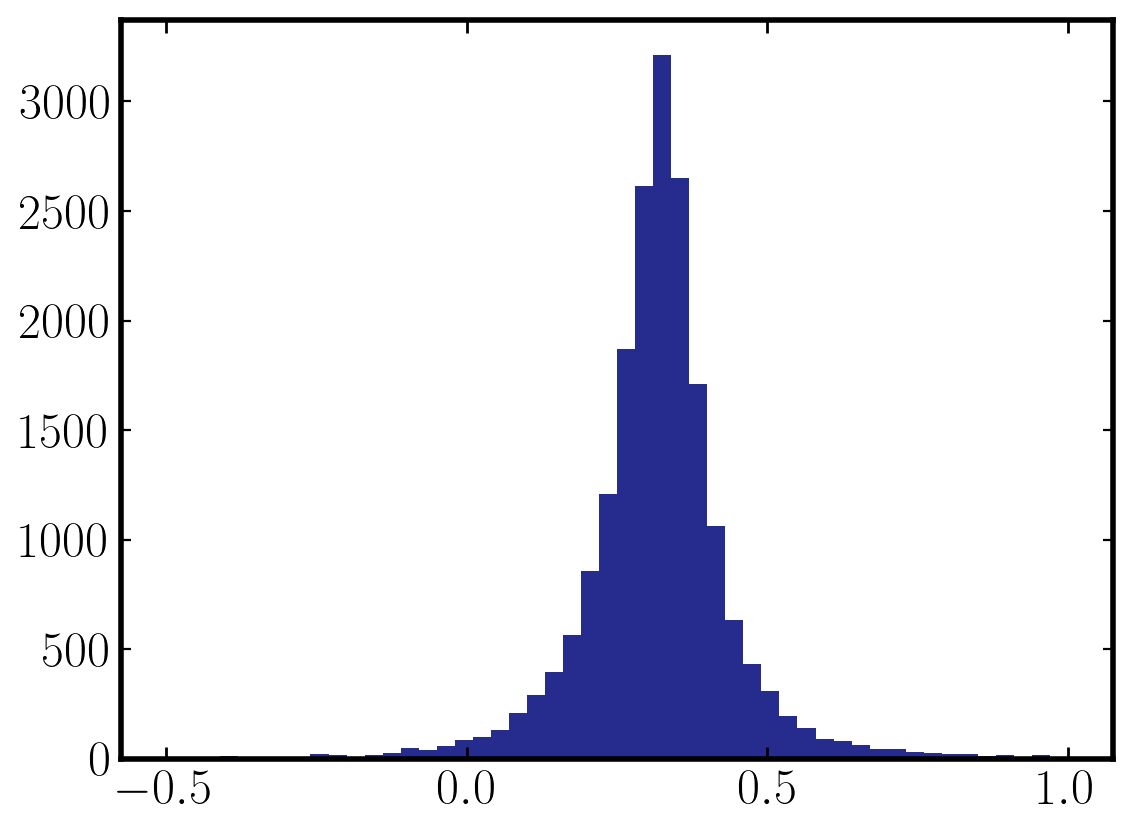

In [26]:
_ = plt.hist(r2_map[mask_map] / num_map[mask_map], bins=50, range=(-0.5, 1))

In [27]:
np.average(r2_map[mask_map] / num_map[mask_map])

0.3206581745895771

In [28]:
np.average(r1_map[mask_map] / num_map[mask_map])

0.3202874334944469

In [ ]:
if False:
    fname = "/gpfs02/work/xiangchong.li/work/hsc_data/s23b/deepCoadd_anacal3/fields/hectomap.fits"
    data = pyfits.getdata(fname)
    fname2 = "/gpfs02/work/xiangchong.li/work/hsc_data/s23b/deepCoadd_anacal3/fields_color/hectomap.fits"
    data2 = pyfits.getdata(fname2)
    data = data[data2["tract"] == data2["tract"][0]]
    stars = fitsio.read("/gpfs02/work/xiangchong.li/work/hsc_data/s23b/gaia/stars.fits")
    stars = stars[(stars["g_mag"] < 14) & (stars["g_mag"] >= 11)] 
    radius = np.zeros(len(stars))
    radius[stars["g_mag"] >= 11]  = 0.52 * 60
    import healsparse as hsp
    def build_disc_mask(
        ra_ref, dec_ref, rad_arcsec,
        nside_cov=32, nside_sparse=4096
    ):
        smap = hsp.HealSparseMap.make_empty(nside_cov, nside_sparse, np.uint8, sentinel=0)
        geoms = [hsp.Circle(ra=float(ra), dec=float(dec), radius=float(r)/3600.0, value=1)
                 for ra, dec, r in zip(ra_ref, dec_ref, rad_arcsec)]
        hsp.realize_geom(geoms, smap) 
        return smap
    hsmask = build_disc_mask(stars["ra"], stars["dec"], radius, nside_sparse=131072 *4)

In [ ]:
np.sum(hsmask.get_values_pos(data["ra"], data["dec"])) / len(data)

In [41]:
if False:
    fnames = glob.glob("/gpfs02/work/xiangchong.li/work/hsc_data/s23b/deepCoadd_anacal3/healpix/*.fits")
    pixlist = np.sort(np.array([a.split("/")[-1][:-5] for a in fnames]).astype(int))
    fitsio.write("/gpfs02/work/xiangchong.li/work/hsc_data/s23b/healpix_list.fits", pixlist)

In [26]:
up1 = 0
up2 = 0
down1 = 0
down2 = 0
field_list = ["spring1", "spring2", "spring3", "autumn1", "autumn2", "hectomap"]
for field in field_list:
    fname = f"/gpfs02/work/xiangchong.li/work/hsc_data/s23b/deepCoadd_anacal3/fields/{field}.fits"
    data = fitsio.read(fname, columns=["g_flux", "r_flux", "i_flux", "z_flux", "y_flux", "e1", "e2", "de1_dg1", "de2_dg2", "wsel", "dwsel_dg1", "dwsel_dg2", "flux"])
    mag = 27.0 - 2.5 * np.log10(data["flux"])
    g = 27.0 - 2.5 * np.log10(data["g_flux"])
    r = 27.0 - 2.5 * np.log10(data["r_flux"])
    i = 27.0 - 2.5 * np.log10(data["i_flux"])
    z = 27.0 - 2.5 * np.log10(data["z_flux"])
    y = 27.0 - 2.5 * np.log10(data["y_flux"])
    abse2 = data["e1"] ** 2.0 + data["e2"] ** 2.0
    mask = (
        (mag < 24.5) &
        (abse2 < 0.09) &
        (r - i <  1.6) & 
        (i - z > -0.8) & 
        (z - y > -1.4)
    )
    data = data[mask]
    up1 += np.sum(data["e1"] * data["wsel"])
    up2 += np.sum(data["e2"] * data["wsel"])
    down1 += np.sum(data["de1_dg1"] * data["wsel"] + data["dwsel_dg1"] * data["e1"])
    down2 += np.sum(data["de2_dg2"] * data["wsel"] + data["dwsel_dg2"] * data["e2"])
    print(np.sum(data["e1"] * data["wsel"]) / np.sum(data["de1_dg1"] * data["wsel"] + data["dwsel_dg1"] * data["e1"]))
    print(np.sum(data["e2"] * data["wsel"]) / np.sum(data["de2_dg2"] * data["wsel"] + data["dwsel_dg2"] * data["e2"]))
    del data, g, r, z, i, y, mask

/tmp/ipykernel_29566/324337237.py:10: RuntimeWarning: invalid value encountered in log10
  g = 27.0 - 2.5 * np.log10(data["g_flux"])
/tmp/ipykernel_29566/324337237.py:11: RuntimeWarning: invalid value encountered in log10
  r = 27.0 - 2.5 * np.log10(data["r_flux"])
/tmp/ipykernel_29566/324337237.py:12: RuntimeWarning: invalid value encountered in log10
  i = 27.0 - 2.5 * np.log10(data["i_flux"])
/tmp/ipykernel_29566/324337237.py:13: RuntimeWarning: invalid value encountered in log10
  z = 27.0 - 2.5 * np.log10(data["z_flux"])
/tmp/ipykernel_29566/324337237.py:14: RuntimeWarning: invalid value encountered in log10
  y = 27.0 - 2.5 * np.log10(data["y_flux"])


-0.0007093059040016663
2.9263036458615482e-05
0.0006130835000161813
0.00030862707433788113
0.00043712416057214363
-0.00031111162985643246
-0.00032044660421499764
-0.0005441074524626974
-0.0002791922322031514
-0.0002780443238034894
-0.00015067179725503224
-5.656737741884292e-05


In [27]:
up1 / down1

-4.947959474029201e-05

In [28]:
up2 / down2

-0.0001589233154747417

In [32]:
(down1 - down2) / down2 / 2.0

-0.004778811201689316